In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Line 3: Mount Google Drive (to upload your dataset or save models)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!unzip -q "/content/drive/My Drive/Dataset_shortest.zip" -d /content/



replace /content/dataset_shortest/Head_Movement_Allowed/ (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
dataset_path = "/content/dataset_shortest"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

Found 20146 files belonging to 2 classes.


In [4]:
EPOCHS = 50


class_names = dataset.class_names
print(class_names)

['Head_Movement_Allowed', 'Head_Movement_Not_Allowed']


In [5]:
len_dataset = len(dataset)
print(f"Total samples: {len_dataset}")

for img, label in dataset.take(1):
    print(img.shape)
    print(label.numpy())

Total samples: 630
(32, 128, 128, 3)
[1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1]


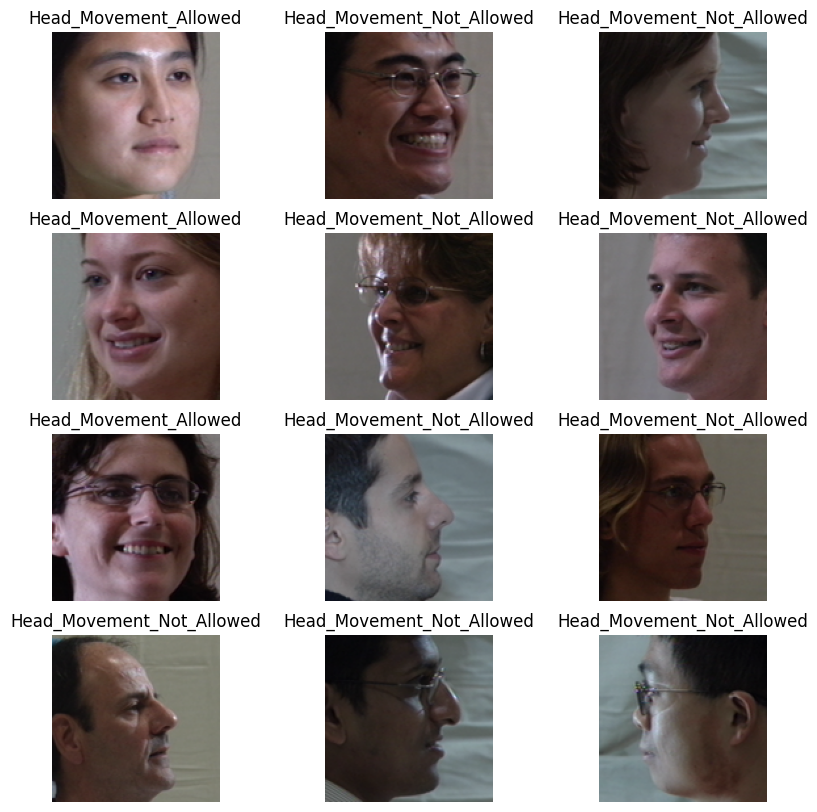

In [6]:
plt.figure(figsize=(10, 10))
for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [8]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1.0 / 255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
BATCH_SIZE = 32
n_classes = 2

model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.7395 - loss: 0.4942 - val_accuracy: 0.9311 - val_loss: 0.1708
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9337 - loss: 0.1704 - val_accuracy: 0.9464 - val_loss: 0.1293
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9496 - loss: 0.1326 - val_accuracy: 0.9360 - val_loss: 0.1644
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9528 - loss: 0.1161 - val_accuracy: 0.9757 - val_loss: 0.0608
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9665 - loss: 0.0882 - val_accuracy: 0.9841 - val_loss: 0.0505
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9724 - loss: 0.0716 - val_accuracy: 0.9638 - val_loss: 0.0873
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9736 - loss: 0.0666 - val_accuracy: 0.9876 - val_loss: 0.0293
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9757 - loss: 0.0657 - 

In [15]:
test_scores = model.evaluate(test_dataset)
test_scores

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9982 - loss: 0.0075


[0.009436388500034809, 0.9975025057792664]

In [16]:
train_scores = model.evaluate(train_dataset)
train_scores

504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9970 - loss: 0.0087


[0.008013952523469925, 0.9967758059501648]

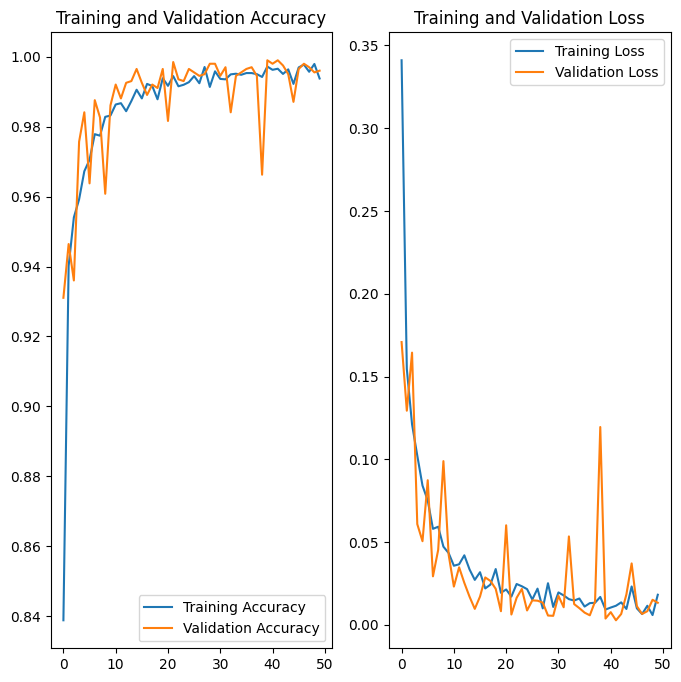

<Figure size 640x480 with 0 Axes>

In [23]:
history_data = history.history
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']
loss = history_data['loss']
val_loss = history_data['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
plt.savefig("Accuracy and Loss of Custom CNN.png")

Actual Label: Head_Movement_Not_Allowed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted Label: Head_Movement_Not_Allowed


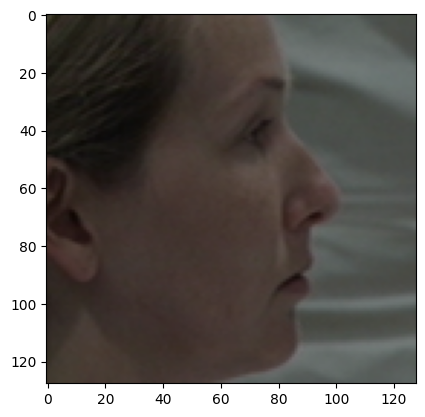

In [18]:
for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_image, cmap='gray')
    print(f"Actual Label: {class_names[first_label]}")

    batch_prediction = model.predict(img)
    predicted_class = np.argmax(batch_prediction[0])
    print(f"Predicted Label: {class_names[predicted_class]}")

In [19]:
model_version = 'CNN_Model1'
model.save(f"/content/drive/My Drive/{model_version}.keras")
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

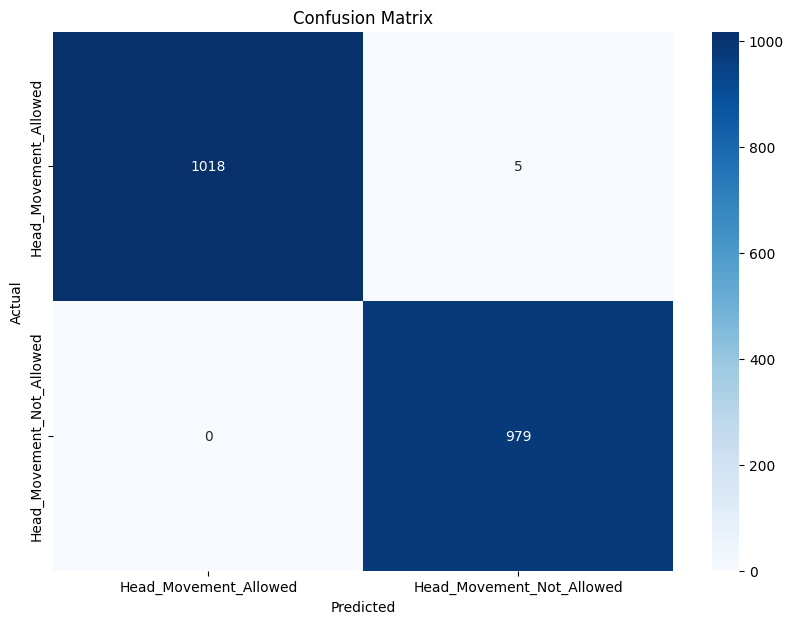

<Figure size 640x480 with 0 Axes>

In [20]:
y_true, y_pred = [], []
for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("Confusion Matrix of Custom CNN.png")

In [21]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.9975151880639684
Recall: 0.9975024975024975
F1 Score: 0.9975026190587319
